In [1]:
import numpy as np
import pandas as pd
from interactions_data import create_index, reset_ids
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import zipfile
import os, shutil

In [2]:
try:
    shutil.rmtree('./ml-100k')
    print('ml-100k directory already exists, removing it first')
except:
    print('no existing directory found, all good')

# stable link for dataset
url = 'http://files.grouplens.org/datasets/movielens/'
filename = 'ml-100k.zip'


# download zip file from link
print('downloading and saving dataset from movielens stable link...')
downloaded = urlopen(url + filename)
buf = downloaded.read()

# save file and extract contents
with open(filename, 'wb') as f:
    f.write(buf)

print('unzipping contents')
with zipfile.ZipFile(filename) as zip:
    zip.extractall('.')
    
# add .txt to readme file
os.rename('./ml-100k/README', './ml-100k/README.txt')

# remove zip file from directory
print('deleting zip file')
os.remove('ml-100k.zip')

no existing directory found, all good
downloading and saving dataset from movielens stable link...
unzipping contents
deleting zip file


In [3]:
path = 'ml-100k/'

In [4]:
df = pd.read_csv(path+'u.data', sep='\t', 
                 names=['userId','movieId','rating','timestamp']).drop('timestamp', axis=1)

In [5]:
df.shape

(100000, 3)

In [6]:
genre_map = pd.read_csv(path+'u.genre', sep='|',
                        names=['genre','code'])

colnames=['movieId','title','releaseDate','blank','link'] + list(genre_map['genre'].values)

In [7]:
movies = pd.read_csv(path+'u.item', sep='|',
                     names=colnames, encoding = "ISO-8859-1").drop('blank', axis=1)

In [8]:
movies.head()

,movieId,title,releaseDate,link,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
users = pd.read_csv(path+'u.user', sep='|',
                    names=['userId','age','gender','occupation','zipcode'])

In [10]:
users.head()

,userId,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [11]:
user_ids = df['userId'].unique()
movie_ids = df['movieId'].unique()

In [12]:
# length before
print(len(movies), len(users))

# keep metadata only for movies that have receieved ratings
movies = movies[movies['movieId'].isin(movie_ids)]
users = users[users['userId'].isin(user_ids)]

# length after
print(len(movies), len(users))

1682 943
1682 943


In [13]:
# create ID encoders
user_encoder, _ = create_index(user_ids)
movie_encoder, _ = create_index(movie_ids)

### Encode IDs from 0-n

In [14]:
# replace all IDs with sequential 0-N IDs
df['userId'] = df['userId'].apply(lambda x: user_encoder[x])
df['movieId'] = df['movieId'].apply(lambda x: movie_encoder[x])

movies['movieId'] = movies['movieId'].apply(lambda x: movie_encoder[x])
users['userId'] = users['userId'].apply(lambda x: user_encoder[x])

In [15]:
n_users = df.userId.nunique()
n_items = df.movieId.nunique()
max_score = df.rating.max()
min_score = df.rating.min()

In [16]:
print(n_users, df.userId.max())
print(n_items, df.movieId.max())
print(min_score, max_score)

943 942
1682 1681
1 5


In [17]:
df.to_csv(path+'ratings.csv', index=False)
movies.to_csv(path+'movies.csv', index=False)
users.to_csv(path+'users.csv', index=False)

### remove all other files

In [18]:
dir_name = "./ml-100k/"
folder = os.listdir(dir_name)

for item in folder:
    if not (item.endswith(".csv") or item.endswith(".txt")):
        os.remove(os.path.join(dir_name, item))

### EDA
Follow [this blog post](http://www.gregreda.com/2013/10/26/using-pandas-on-the-movielens-dataset/) for some examples

In [19]:
df = pd.read_csv(path+'ratings.csv')
movies = pd.read_csv(path+'movies.csv')
users = pd.read_csv(path+'users.csv')

# create one merged DataFrame
df = pd.merge(movies, df)[['userId','movieId','rating','title']]
df = pd.merge(df, users)

In [20]:
df.head()

,userId,movieId,rating,title,age,gender,occupation,zipcode
0,23,24,4,Toy Story (1995),60,M,retired,95076
1,23,47,5,Get Shorty (1995),60,M,retired,95076
2,23,75,4,Copycat (1995),60,M,retired,95076
3,23,209,4,Twelve Monkeys (1995),60,M,retired,95076
4,23,389,5,Babe (1995),60,M,retired,95076


In [21]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (16,9),
            'font.family': 'serif'})

# # use LaTeX fonts in the plot
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

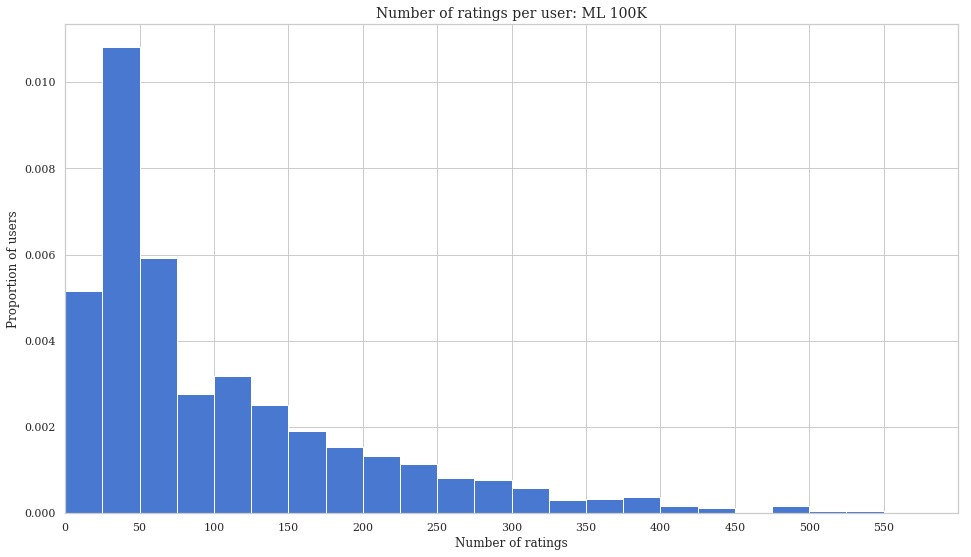

Min ratings by single user: 20
Max ratings by single user: 737
Avg number of ratings per user: 106


In [26]:
user_counts = df['userId'].value_counts()

plt.hist(user_counts, bins=np.arange(0,551,25), density=True)
# plt.hist(user_counts, bins=np.arange(0,551,25), density=True, cumulative=True, histtype='step')
plt.title('Number of ratings per user: ML 100K', fontsize=14)
plt.xlabel('Number of ratings', fontsize=12)
plt.ylabel('Proportion of users', fontsize=12)
plt.xlim(0, 600)
plt.xticks(np.arange(0,551,50))
plt.savefig('../figures/ml_10k_user-ratings.pdf', bbox_inches='tight')
plt.show()

# user with fewest ratings
print('Min ratings by single user:',
      user_counts.min())

# user with most ratings
print('Max ratings by single user:',
      user_counts.max())

# average number of ratings per user
print('Avg number of ratings per user:',
      round(user_counts.mean()))

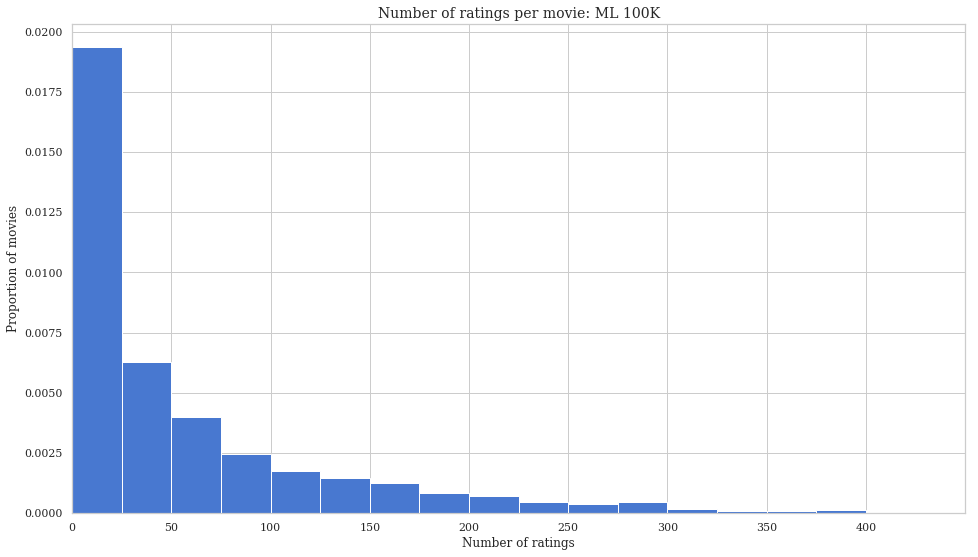

Min ratings of single movie: 1
Max ratings of single movie: 583
Avg number of ratings per movie: 60


In [25]:
movie_counts = df['title'].value_counts()

plt.hist(movie_counts, bins=np.arange(0,401,25), density=True)
# plt.hist(user_counts, bins=np.arange(0,401,25), density=True, cumulative=True, histtype='step')
plt.title('Number of ratings per movie: ML 100K', fontsize=14)
plt.xlabel('Number of ratings', fontsize=12)
plt.ylabel('Proportion of movies', fontsize=12)
plt.xlim(0, 450)
plt.xticks(np.arange(0,401,50))
plt.savefig('../figures/ml_10k_movie-ratings.pdf', bbox_inches='tight')
plt.show()

# movie with fewest ratings
print('Min ratings of single movie:',
      movie_counts.min())

# movie with most ratings
print('Max ratings of single movie:',
      movie_counts.max())

# average number of ratings per book
print('Avg number of ratings per movie:',
      round(movie_counts.mean()))

In [34]:
movie_counts.head()

Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: title, dtype: int64

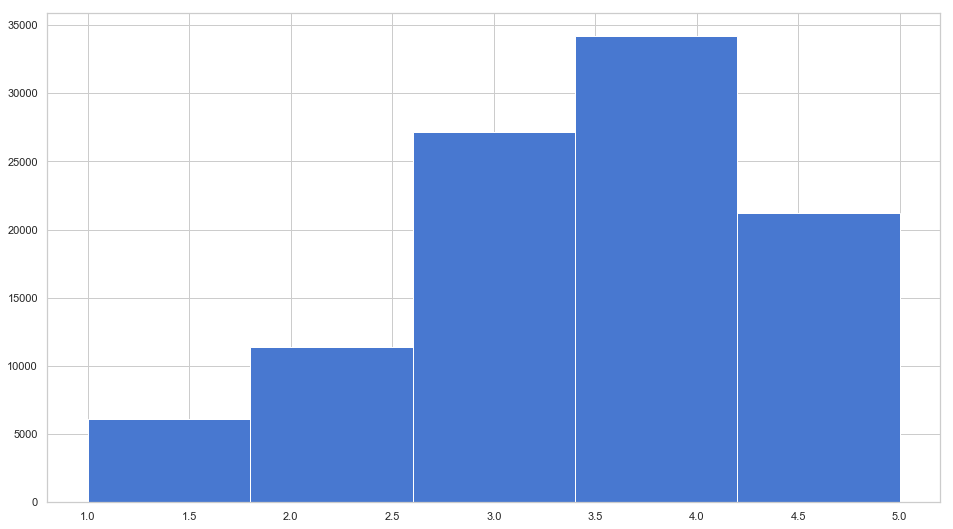

Avg rating: 3.53


In [36]:
plt.hist(df['rating'].values, bins=5)
plt.xlim(0,5)
plt.show()

print('Avg rating:', round(df['rating'].mean(),2))